<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/hccho2/DL-UPMTP/blob/master/DL-TF-TORCH-CH5-TF-Custom-Training.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 런타임 다시 시작해야 함.

In [ ]:
import matplotlib.pyplot as plt
plt.rc('font',family='NanumBarunGothic')

# 5.1 사용자 정의 Callback Class

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
plt.style.use("seaborn-v0_8")

In [ ]:
class LossAndAccuracyPrintingCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_loss = []
        self.epoch_accuracy = []

    def on_train_batch_end(self, batch, logs=None):
        # ~logs["loss"] = mini batch에 대한 loss~
        print("For batch {}, loss is {:7.4f}".format(batch, logs["loss"]))
        self.epoch_loss.append(logs["loss"])
        self.epoch_accuracy.append(logs["accuracy"])

    def on_test_batch_end(self, batch, logs=None):
        print("For batch {}, loss is {:7.4f}".format(batch, logs["loss"]))

    def on_epoch_end(self, epoch, logs=None):
        print("The average train loss for epoch {} is {:7.4f} "
              "and train accuracy is {:7.4f}.".format(epoch, np.mean(self.epoch_loss), np.mean(self.epoch_accuracy)))

In [ ]:
class PlotCallback(tf.keras.callbacks.Callback):

    def on_train_begin(self, logs=None):
        self.logs = dict()

    def on_epoch_end(self, epoch, logs=None):
        for key, val in logs.items():
            if key not in self.logs:
                self.logs[key] = []
            self.logs[key].append(val)

        #self.plot_logs_all()
        self.plot_logs()

    def plot_logs_all(self):
        clear_output(wait=True)
        num_metrics = len(self.logs)
        self.fig, self.ax = plt.subplots(math.ceil(num_metrics / 2), 2, figsize=(10, 8))

        # Plotting:
        i = 0
        for key, val in self.logs.items():
            row, col = i // 2, i % 2
            self.ax[row, col].clear()
            self.ax[row, col].set_title(key)
            self.ax[row, col].plot(val)
            i += 1

        self.fig.tight_layout()
        self.fig.subplots_adjust(right=0.75, bottom=0.25)
        plt.pause(1e-17)


    def plot_logs(self):
        clear_output(wait=True)
        fig, ax = plt.subplots(1, 2, figsize=(10, 4))

        ax[0].clear()
        ax[1].clear()
        for key, val in self.logs.items():
            if key.find('loss') >=0:
                ax[0].plot(val,label=key)
            elif key.find('accuracy')>=0:
                ax[1].plot(val,label=key)
        ax[0].legend()
        ax[1].legend()
        ax[0].set_title('loss')
        ax[1].set_title('accuracy')

        plt.tight_layout()
        plt.pause(1e-17)

In [ ]:
# Dataset 준비
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()  # numpy array
x_train = tf.cast(x_train.reshape(-1,28*28)/255.,tf.float32)
x_test = tf.cast(x_test.reshape(-1,28*28)/255.,tf.float32)
train_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train)).shuffle(2000).batch(64)
val_dataset = tf.data.Dataset.from_tensor_slices((x_test,y_test)).batch(64)

model = tf.keras.Sequential([tf.keras.layers.Dense(512,activation='relu'),tf.keras.layers.Dense(10,activation=None)])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer,loss=loss_fn,metrics=['accuracy'])

plot_cb = PlotCallback()

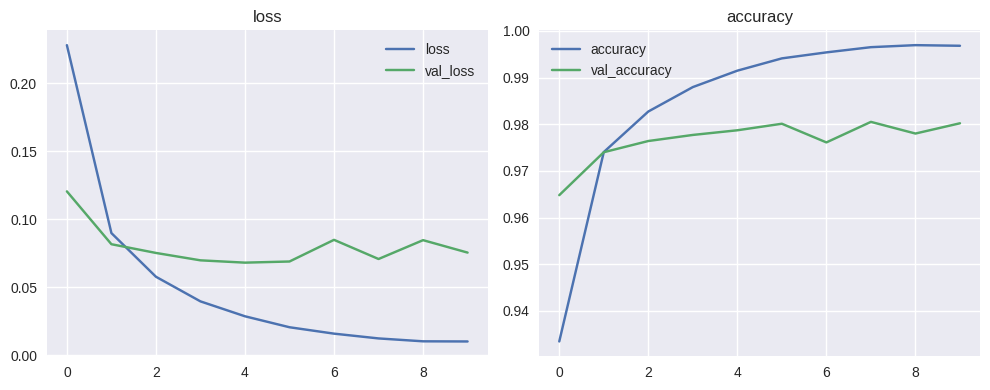

938/938 [==============================] - 9s 10ms/step - loss: 0.0100 - accuracy: 0.9968 - val_loss: 0.0753 - val_accuracy: 0.9802


In [ ]:
print(tf.test.is_gpu_available())
history = model.fit(train_dataset,epochs=10,verbose=1, validation_data=val_dataset, callbacks=[plot_cb])

# 5.2 Custom Metric Function

### Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

              precision    recall  f1-score   support

           0     0.8889    0.8000    0.8421        10
           1     0.5714    0.6667    0.6154         6
           2     0.6667    0.6667    0.6667         6

    accuracy                         0.7273        22
   macro avg     0.7090    0.7111    0.7081        22
weighted avg     0.7417    0.7273    0.7324        22

confusion matrix:
 [[8 1 1]
 [1 4 1]
 [0 2 4]]


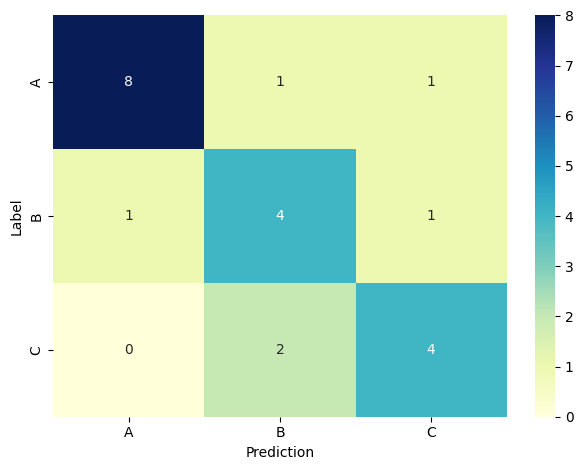

In [ ]:
# 3 class classification
label = np.array([0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,2,2,2,2,2,2])
pred =  np.array([0,0,0,0,0,0,0,0,1,2,0,1,1,1,1,2,1,1,2,2,2,2])
class_names = ['A','B','C']
confusion_matrix_ = confusion_matrix(label, pred)

print(classification_report(label,pred,digits=4))
print("confusion matrix:\n",confusion_matrix_)

# visualization
sns.heatmap(confusion_matrix_, xticklabels=class_names, yticklabels=class_names, annot=True,cmap="YlGnBu")  # cmap="Blues"
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.tight_layout()
plt.show()

### Custom Metrics로 train하기

In [ ]:
import tensorflow as tf

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()  # numpy array
x_train = tf.cast(x_train.reshape(-1,28*28)/255.,tf.float32)
x_test = tf.cast(x_test.reshape(-1,28*28)/255.,tf.float32)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train)).shuffle(2000).batch(256)
val_dataset = tf.data.Dataset.from_tensor_slices((x_test,y_test)).batch(64)

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
class PrecisionRecall(tf.keras.metrics.Metric):
    def __init__(self, name="PrecisionRecall", **kwargs):
        super(PrecisionRecall, self).__init__(name=name, **kwargs)
        self.precision = self.add_weight(name='precision',initializer=tf.keras.initializers.Zeros())
        self.recall = self.add_weight(name='recall',initializer=tf.keras.initializers.Zeros())
        self.f1_score = self.add_weight(name='f1_score',initializer=tf.keras.initializers.Zeros())

    def update_state(self, y_true, y_pred,sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        confusion = tf.math.confusion_matrix(y_true,y_pred,dtype=tf.float32)
        confusion_diag = tf.linalg.diag_part(confusion)
        pred_sum = tf.add(tf.reduce_sum(confusion,axis=0),1e-7)  # TP + FP
        actual_sum = tf.add(tf.reduce_sum(confusion,axis=1),1e-7) # TP + FN

        precision = confusion_diag/pred_sum
        recall = confusion_diag/actual_sum
        f1_score = 2*(precision*recall)/(precision+recall+1e-7)
        self.precision.assign(tf.reduce_mean(precision))
        self.recall.assign(tf.reduce_mean(recall))
        self.f1_score.assign(tf.reduce_mean(f1_score))

    def result(self):
        return {"precision": self.precision, "recall": self.recall, "f1_score": self.f1_score}

    def reset_state(self):
        self.precision.assign(0.0)
        self.recall.assign(0.0)
        self.f1_score.assign(0.0)

In [ ]:
print(tf.test.is_gpu_available())

model = tf.keras.Sequential([tf.keras.layers.Dense(512,activation='relu'),tf.keras.layers.Dense(10,activation=None)])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

recall_cb = PrecisionRecall()
model.compile(optimizer,loss=loss_fn,metrics=['accuracy',recall_cb])

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False


In [ ]:
history = model.fit(train_dataset, epochs=2,verbose=1,validation_data=val_dataset)

Epoch 1/2
235/235 [==============================] - 13s 36ms/step - loss: 0.3300 - accuracy: 0.9086 - precision: 0.9097 - recall: 0.9082 - f1_score: 0.9056 - val_loss: 0.1698 - val_accuracy: 0.9505 - val_precision: 1.0000 - val_recall: 1.0000 - val_f1_score: 1.0000
Epoch 2/2
235/235 [==============================] - 9s 37ms/step - loss: 0.1375 - accuracy: 0.9604 - precision: 0.9606 - recall: 0.9604 - f1_score: 0.9597 - val_loss: 0.1161 - val_accuracy: 0.9647 - val_precision: 1.0000 - val_recall: 1.0000 - val_f1_score: 1.0000


In [ ]:
class PrecisionRecall2(tf.keras.metrics.Metric):
    def __init__(self, name="PrecisionRecall", **kwargs):
        super(PrecisionRecall2, self).__init__(name=name, **kwargs)
        self.precision = self.add_weight(name='precision',initializer=tf.keras.initializers.Zeros())
        self.recall = self.add_weight(name='recall',initializer=tf.keras.initializers.Zeros())
        self.f1_score = self.add_weight(name='f1_score',initializer=tf.keras.initializers.Zeros())
        self.example_num = self.add_weight(name='example_num', initializer='zeros')

    def update_state(self, y_true, y_pred,sample_weight=None):

        y_pred = tf.argmax(y_pred, axis=-1)
        confusion = tf.math.confusion_matrix(y_true,y_pred,dtype=tf.float32)
        confusion_diag = tf.linalg.diag_part(confusion)
        pred_sum = tf.add(tf.reduce_sum(confusion,axis=0),1e-7)  # TP + FP
        actual_sum = tf.add(tf.reduce_sum(confusion,axis=1),1e-7) # TP + FN

        precision = confusion_diag/pred_sum
        recall = confusion_diag/actual_sum
        f1_score = 2*(precision*recall)/(precision+recall+1e-7)
        self.precision.assign_add(tf.reduce_mean(precision))
        self.recall.assign_add(tf.reduce_mean(recall))
        self.f1_score.assign_add(tf.reduce_mean(f1_score))

        self.example_num.assign_add(1.0)

    def result(self):
        return {"precision": self.precision/self.example_num, "recall": self.recall/self.example_num, "f1_score": self.f1_score/self.example_num}

    def reset_state(self):
        self.precision.assign(0.0)
        self.recall.assign(0.0)
        self.f1_score.assign(0.0)
        self.example_num.assign(0.0)

# 5.3 train_step/test_step 재정의

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()  # numpy array uint8
x_train = tf.cast(x_train.reshape(-1,28*28)/255.,tf.float32)
x_test = tf.cast(x_test.reshape(-1,28*28)/255.,tf.float32)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train)).shuffle(2000).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((x_test,y_test)).batch(64)

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
class MyModel(tf.keras.Model):
    def __init__(self,**kwargs):
        super(MyModel, self).__init__(**kwargs)
        self.L1 = tf.keras.layers.Dense(units=512,activation='relu',name='L1')
        self.L2 = tf.keras.layers.Dense(units=10,activation=None,name='L2')
    def call(self,x,training=None):
        output = self.L1(x)
        output = self.L2(output)
        return output

    @tf.function
    def train_step(self, data):
        x, y = data  # Unpack the data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # compile과정에서 설정된 loss함수를 self.compiled_loss로 불러올 수 있다.
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        gradients = tape.gradient(loss, self.trainable_variables)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # 기본적으로 loss값을 출력을 위한 Metric이 있고, 추가로 넘겨운 Metric이 더 있을 수 있다.
        self.compiled_metrics.update_state(y, y_pred)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        # evaluation step
        x, y = data # Unpack the data

        # Compute predictions
        y_pred = self(x, training=False)
        self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        self.compiled_metrics.update_state(y, y_pred)

        return {m.name: m.result() for m in self.metrics}

model = MyModel()

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer,loss=loss_fn,metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,verbose=1,validation_data=val_dataset)

Epoch 1/10
1875/1875 [==============================] - 17s 8ms/step - loss: 0.1950 - accuracy: 0.9427 - val_loss: 0.1248 - val_accuracy: 0.9622
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0790 - accuracy: 0.9754 - val_loss: 0.0818 - val_accuracy: 0.9739
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0508 - accuracy: 0.9842 - val_loss: 0.0716 - val_accuracy: 0.9778
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0344 - accuracy: 0.9891 - val_loss: 0.0783 - val_accuracy: 0.9755
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0269 - accuracy: 0.9914 - val_loss: 0.0733 - val_accuracy: 0.9786
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0192 - accuracy: 0.9939 - val_loss: 0.0820 - val_accuracy: 0.9780
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0156 - accuracy: 0.9948 - val_loss: 0.0836 - val_accuracy

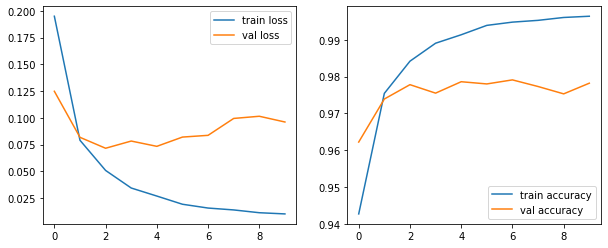

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label="train loss")
plt.plot(history.history['val_loss'],label="val loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'],label="train accuracy")
plt.plot(history.history['val_accuracy'],label="val accuracy")
plt.legend()

# 5.4 Scratch Training: for loop로 밑바닥부터 training

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time

In [ ]:
np.random.seed(100); tf.random.set_seed(100)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()  # numpy array(uint8)
x_train = tf.cast(x_train.reshape(-1,28*28)/255.,tf.float32)  # (60000,784), float64 -> float32
x_test = tf.cast(x_test.reshape(-1,28*28)/255.,tf.float32)    # (10000,784)
batch_size=256
train_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train)).shuffle(buffer_size=20000).batch(batch_size)
validation_dataset = tf.data.Dataset.from_tensor_slices((x_test,y_test)).batch(batch_size)

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
model = tf.keras.Sequential([tf.keras.layers.Dense(512,activation='relu'),
                                    tf.keras.layers.Dense(10,activation=None)])

if False:
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
else:
    initial_learning_rate = 0.01
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                            decay_steps=100,decay_rate=0.99,staircase=False)

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) #default: from_logits=False

train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

train_loss_metric = tf.keras.metrics.Mean()
val_loss_metric = tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
def train_step(x,y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)

    grads = tape.gradient(loss_value, model.trainable_weights)

    optimizer.apply_gradients(zip(grads, model.trainable_weights))  # callable learning rate decay
    train_acc_metric.update_state(y, logits)
    train_loss_metric.update_state(loss_value)

def test_step(x,y):
    logits = model(x, training=False)
    val_loss_metric.update_state(y, logits)
    val_acc_metric.update_state(y, logits)

In [ ]:
num_epochs = 15
best_acc = 0.
best_duration = 0
start_time = time.time()
for epoch in range(num_epochs):

    for step, (x, y) in enumerate(train_dataset):
        train_step(x,y)

    print(f'[epoch: {epoch+1:0>3}/{num_epochs}] loss: {train_loss_metric.result():.4f}, train acc: {train_acc_metric.result():.4f} elapsed: {time.time()-start_time:.2f}sec',end="\t" )
    train_acc_metric.reset_state()  # epoch 마다 reset
    train_loss_metric.reset_state()

    for step, (x, y) in enumerate(validation_dataset):
        test_step(x,y)

    if val_acc_metric.result() > best_acc:
        best_acc = val_acc_metric.result()
        print(f'val loss: {val_loss_metric.result():.4f}, test acc: {best_acc:.5f}, best: {best_acc:.4f} ===== new best')
        best_duration = 0
    else:
        best_duration += 1
        print(f'val loss: {val_loss_metric.result():.4f}, test acc: {val_acc_metric.result():.4f}, best: {best_acc:.4f}, best duration: {best_duration}')

    val_loss_metric.reset_state()
    val_acc_metric.reset_state()
print('Done')

[epoch: 001/15] loss: 0.2333, train acc: 0.9299 elapsed: 41.93sec	val loss: 0.0966, test acc: 0.97100, best: 0.9710 ===== new best
[epoch: 002/15] loss: 0.0874, train acc: 0.9728 elapsed: 52.67sec	val loss: 0.0929, test acc: 0.97210, best: 0.9721 ===== new best
[epoch: 003/15] loss: 0.0667, train acc: 0.9787 elapsed: 63.36sec	val loss: 0.1047, test acc: 0.9701, best: 0.9721, best duration: 1
[epoch: 004/15] loss: 0.0511, train acc: 0.9832 elapsed: 74.22sec	val loss: 0.0916, test acc: 0.97590, best: 0.9759 ===== new best
[epoch: 005/15] loss: 0.0414, train acc: 0.9869 elapsed: 84.29sec	val loss: 0.0929, test acc: 0.9749, best: 0.9759, best duration: 1
[epoch: 006/15] loss: 0.0351, train acc: 0.9882 elapsed: 105.24sec	val loss: 0.1082, test acc: 0.9749, best: 0.9759, best duration: 2
[epoch: 007/15] loss: 0.0292, train acc: 0.9905 elapsed: 115.92sec	val loss: 0.1085, test acc: 0.97680, best: 0.9768 ===== new best
[epoch: 008/15] loss: 0.0329, train acc: 0.9896 elapsed: 126.42sec	val loss

In [ ]:
optimizer._decayed_lr(tf.float32).numpy(),optimizer.iterations.numpy()

(0.007016827, 3525)

# 5.5 사용자 정의 Loss Function & tf.function decorator

## 5.5.1 사용자 정의 Loss Function

In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
def custom_mean_squared_error(y_true, y_pred):
    return tf.math.reduce_mean(tf.square(y_true - y_pred))

In [ ]:
class CustomMSE(keras.losses.Loss):
    def __init__(self, regularization_factor=0.1, name="custom_mse"):
        super().__init__(name=name)
        self.regularization_factor = regularization_factor

    def call(self, y_true, y_pred):
        mse = tf.math.reduce_mean(tf.square(y_true - y_pred))
        reg = tf.math.reduce_mean(tf.square(0.5 - y_pred))
        return mse + reg * self.regularization_factor

## 5.5.2 Multi Loss Function

In [ ]:
x1 = tf.keras.Input(shape=(10,),name='input_1')
x2 = tf.keras.Input(shape=(5,),name='input_2')

x = tf.keras.layers.Dense(100,activation='relu')(x1)
y = tf.keras.layers.Dense(100,activation='relu')(x2)
z = tf.keras.layers.concatenate([x,y],axis=-1)
z = tf.keras.layers.Dense(100,activation='relu')(z)
z = tf.keras.layers.Dense(100,activation='relu')(z)
pred_score= tf.keras.layers.Dense(1,activation=None,name='score')(z)
pred_pass= tf.keras.layers.Dense(1,activation='sigmoid',name='pass')(z)
model = tf.keras.Model(inputs=[x1,x2],outputs=[pred_score,pred_pass])

model.compile('sgd',loss=['mse','bce'],loss_weights=[0.6,0.4])

#model.compile('sgd',loss={'score': 'mse', 'pass': 'bce'},loss_weights={'score': 0.6, 'pass': 0.4})

In [ ]:
data_x1 = np.random.randn(2,10)
data_x2 = np.random.randn(2,5)
output1, output2 = model([data_x1,data_x2],training=False)
output1.shape, output2.shape

(TensorShape([2, 1]), TensorShape([2, 1]))

In [ ]:
N=1000
data_x1 = np.random.randn(N,10)
data_x2 = np.random.randn(N,5)
taget_score = np.random.randn(N)
target_pass = np.random.randint(2,size=N)

model.fit([data_x1,data_x2],[taget_score,target_pass], batch_size=32,epochs=10)
#model.fit({'input_1': data_x1, 'input_2': data_x2},{'score': taget_score, 'pass': target_pass}, batch_size=32,epochs=10)

Epoch 1/10
32/32 [==============================] - 2s 4ms/step - loss: 0.9015 - score_loss: 1.0333 - pass_loss: 0.7039
Epoch 2/10
32/32 [==============================] - 0s 4ms/step - loss: 0.8906 - score_loss: 1.0165 - pass_loss: 0.7017
Epoch 3/10
32/32 [==============================] - 0s 5ms/step - loss: 0.8850 - score_loss: 1.0084 - pass_loss: 0.6999
Epoch 4/10
32/32 [==============================] - 0s 4ms/step - loss: 0.8788 - score_loss: 0.9988 - pass_loss: 0.6987
Epoch 5/10
32/32 [==============================] - 0s 4ms/step - loss: 0.8737 - score_loss: 0.9911 - pass_loss: 0.6977
Epoch 6/10
32/32 [==============================] - 0s 4ms/step - loss: 0.8696 - score_loss: 0.9848 - pass_loss: 0.6968
Epoch 7/10
32/32 [==============================] - 0s 4ms/step - loss: 0.8658 - score_loss: 0.9788 - pass_loss: 0.6963
Epoch 8/10
32/32 [==============================] - 0s 4ms/step - loss: 0.8612 - score_loss: 0.9717 - pass_loss: 0.6955
Epoch 9/10
32/32 [======================

## 5.5.3 다중 출력의 Loss 계산
- loss를 layer로 구현하기
- self.add_loss

In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
class LogitLayer(tf.keras.layers.Layer):
    def __init__(self, name=None):
        super(LogitLayer, self).__init__(name=name)
        self.loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,name='my_loss')
        self.accuracy_fn = tf.keras.metrics.SparseCategoricalAccuracy()  # name="my_accuracy"

    def call(self, targets, logits):
        loss = self.loss_fn(targets, logits)
        self.add_loss(loss)

        acc = self.accuracy_fn(targets, logits)
        self.add_metric(acc,name="std_of_activation", aggregation="mean")

        return tf.nn.softmax(logits)

In [ ]:
np.random.seed(100); tf.random.set_seed(100)

inputs = tf.keras.Input(shape=(784,), name="inputs")
targets = tf.keras.Input(shape=(), name="targets")
hidden = tf.keras.layers.Dense(512,activation='relu')(inputs)
logits = tf.keras.layers.Dense(10)(hidden)
predictions = LogitLayer(name="predictions")(targets, logits)

model = tf.keras.Model(inputs=[inputs, targets], outputs=predictions)
model.compile(optimizer="adam")  # loss, metrics를 지정하지 않는다.

In [ ]:
# Data 준비
def mymap(x,y):
    return (x,y),None  # 두번째는 dummy

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()  # numpy array(uint8)
x_train = tf.cast(x_train.reshape(-1,28*28)/255.,tf.float32)  # (60000,784), float64 -> float32
x_test = tf.cast(x_test.reshape(-1,28*28)/255.,tf.float32)    # (10000,784)
batch_size=256
train_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train)).map(mymap).shuffle(buffer_size=20000).batch(batch_size)
validation_dataset = tf.data.Dataset.from_tensor_slices((x_test,y_test)).map(mymap).batch(batch_size)

In [ ]:
history = model.fit(train_dataset, epochs=6,verbose=1,validation_data=validation_dataset)

Epoch 1/6
235/235 [==============================] - 4s 14ms/step - loss: 0.3246 - sparse_categorical_accuracy: 0.9112 - val_loss: 0.1660 - val_sparse_categorical_accuracy: 0.9519
Epoch 2/6
235/235 [==============================] - 3s 14ms/step - loss: 0.1380 - sparse_categorical_accuracy: 0.9606 - val_loss: 0.1110 - val_sparse_categorical_accuracy: 0.9662
Epoch 3/6
235/235 [==============================] - 3s 14ms/step - loss: 0.0937 - sparse_categorical_accuracy: 0.9725 - val_loss: 0.0881 - val_sparse_categorical_accuracy: 0.9718
Epoch 4/6
235/235 [==============================] - 3s 14ms/step - loss: 0.0685 - sparse_categorical_accuracy: 0.9802 - val_loss: 0.0783 - val_sparse_categorical_accuracy: 0.9755
Epoch 5/6
235/235 [==============================] - 3s 14ms/step - loss: 0.0521 - sparse_categorical_accuracy: 0.9855 - val_loss: 0.0695 - val_sparse_categorical_accuracy: 0.9778
Epoch 6/6
235/235 [==============================] - 3s 14ms/step - loss: 0.0418 - sparse_categorica

### model.add_loss로 처리하기

In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
np.random.seed(100); tf.random.set_seed(100)

inputs = tf.keras.Input(shape=(784,), name="inputs")
targets = tf.keras.Input(shape=(), name="targets",dtype=tf.int32)
hidden = tf.keras.layers.Dense(512,activation='relu')(inputs)
logits = tf.keras.layers.Dense(10)(hidden)

model = tf.keras.Model(inputs=[inputs, targets], outputs=logits)


#loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#loss = loss_fn(targets, logits) # OK
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(targets, logits))  # targets: int32, int64만 허용.
loss += 0.01*tf.reduce_mean(tf.abs(hidden))
model.add_loss(loss)

acc = tf.reduce_mean(tf.cast(tf.equal(targets,tf.argmax(logits,axis=-1,output_type=tf.int32)),tf.float32))
model.add_metric(acc, name = 'my_acc')  # name을 반드시 넣어주어야 한다.
model.compile(optimizer="adam")  # loss, metrics를 지정하지 않는다.

In [ ]:
# Data 준비
def mymap(x,y):
    return (x,y),None  # 두번째는 dummy

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()  # numpy array(uint8)
x_train = tf.cast(x_train.reshape(-1,28*28)/255.,tf.float32)  # (60000,784), float64 -> float32
x_test = tf.cast(x_test.reshape(-1,28*28)/255.,tf.float32)    # (10000,784)
batch_size=256
train_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train)).map(mymap).shuffle(buffer_size=20000).batch(batch_size)
validation_dataset = tf.data.Dataset.from_tensor_slices((x_test,y_test)).map(mymap).batch(batch_size)

In [ ]:
history = model.fit(train_dataset, epochs=6,verbose=1,validation_data=validation_dataset)

Epoch 1/6
235/235 [==============================] - 4s 16ms/step - loss: 0.3313 - my_acc: 0.9092 - val_loss: 0.1663 - val_my_acc: 0.9551
Epoch 2/6
235/235 [==============================] - 4s 15ms/step - loss: 0.1407 - my_acc: 0.9614 - val_loss: 0.1209 - val_my_acc: 0.9651
Epoch 3/6
235/235 [==============================] - 4s 17ms/step - loss: 0.0970 - my_acc: 0.9739 - val_loss: 0.1052 - val_my_acc: 0.9704
Epoch 4/6
235/235 [==============================] - 4s 15ms/step - loss: 0.0725 - my_acc: 0.9804 - val_loss: 0.0852 - val_my_acc: 0.9749
Epoch 5/6
235/235 [==============================] - 3s 15ms/step - loss: 0.0559 - my_acc: 0.9856 - val_loss: 0.0798 - val_my_acc: 0.9771
Epoch 6/6
235/235 [==============================] - 3s 15ms/step - loss: 0.0446 - my_acc: 0.9886 - val_loss: 0.0750 - val_my_acc: 0.9775


## 5.5.4 @tf.function decorator

In [ ]:
import tensorflow as tf

In [ ]:
@tf.function
def my_function(a,b,c):
  x = tf.matmul(a+b,c)
  return x

In [ ]:
a = tf.constant([[1.0, 2.0]])
b = tf.constant([[2.0, 3.0]])
c = tf.constant([[1.0],[2.0]])
my_function(a,b,c).numpy()

array([[13.]], dtype=float32)

### tf.function decorator

In [ ]:
np.random.seed(100); tf.random.set_seed(100)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()  # numpy array(uint8)
x_train = tf.cast(x_train.reshape(-1,28*28)/255.,tf.float32)  # (60000,784), float64 -> float32
x_test = tf.cast(x_test.reshape(-1,28*28)/255.,tf.float32)    # (10000,784)
batch_size=256
train_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train)).shuffle(buffer_size=20000).batch(batch_size,drop_remainder=True)
validation_dataset = tf.data.Dataset.from_tensor_slices((x_test,y_test)).batch(batch_size)

In [ ]:
model = tf.keras.Sequential([tf.keras.layers.Dense(512,activation='relu'),
                                    tf.keras.layers.Dense(10,activation=None)])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) #default: from_logits=False

train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

train_loss_metric = tf.keras.metrics.Mean()
val_loss_metric = tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
train_step_signature = [tf.TensorSpec(shape=(batch_size, 784), dtype=tf.float32),tf.TensorSpec(shape=(batch_size,), dtype=tf.uint8)]

@tf.function(input_signature=train_step_signature)
def train_step(x,y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)

    grads = tape.gradient(loss_value, model.trainable_weights)

    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y, logits)
    train_loss_metric.update_state(loss_value)

test_step_signature = [tf.TensorSpec(shape=(None, 784), dtype=tf.float32),tf.TensorSpec(shape=(None,), dtype=tf.uint8)]
@tf.function(input_signature=test_step_signature)
def test_step(x,y):
    logits = model(x, training=False)
    val_loss_metric.update_state(y, logits)
    val_acc_metric.update_state(y, logits)

In [ ]:
num_epochs = 15
best_acc = 0.
best_duration = 0
start_time = time.time()
for epoch in range(num_epochs):

    for step, (x, y) in enumerate(train_dataset):
        train_step(x,y)

    print(f'[epoch: {epoch+1:0>3}/{num_epochs}] loss: {train_loss_metric.result():.4f}, train acc: {train_acc_metric.result():.4f} elapsed: {time.time()-start_time:.2f}sec',end="\t" )
    train_acc_metric.reset_states()  # epoch 마다 reset
    train_loss_metric.reset_states()

    for step, (x, y) in enumerate(validation_dataset):
        test_step(x,y)

    if val_acc_metric.result() > best_acc:
        best_acc = val_acc_metric.result()
        print(f'val loss: {val_loss_metric.result():.4f}, test acc: {best_acc:.5f}, best: {best_acc:.4f} ===== new best')
        best_duration = 0
    else:
        best_duration += 1
        print(f'val loss: {val_loss_metric.result():.4f}, test acc: {val_acc_metric.result():.4f}, best: {best_acc:.4f}, best duration: {best_duration}')

    val_loss_metric.reset_states()
    val_acc_metric.reset_states()
print('Done')

[epoch: 001/15] loss: 0.3300, train acc: 0.9089 elapsed: 3.92sec	val loss: 0.1658, test acc: 0.95150, best: 0.9515 ===== new best
[epoch: 002/15] loss: 0.1382, train acc: 0.9606 elapsed: 8.04sec	val loss: 0.1154, test acc: 0.96630, best: 0.9663 ===== new best
[epoch: 003/15] loss: 0.0936, train acc: 0.9732 elapsed: 12.05sec	val loss: 0.0972, test acc: 0.97000, best: 0.9700 ===== new best
[epoch: 004/15] loss: 0.0690, train acc: 0.9805 elapsed: 16.18sec	val loss: 0.0818, test acc: 0.97440, best: 0.9744 ===== new best
[epoch: 005/15] loss: 0.0520, train acc: 0.9851 elapsed: 20.78sec	val loss: 0.0755, test acc: 0.97800, best: 0.9780 ===== new best
[epoch: 006/15] loss: 0.0418, train acc: 0.9887 elapsed: 25.59sec	val loss: 0.0675, test acc: 0.97870, best: 0.9787 ===== new best
[epoch: 007/15] loss: 0.0316, train acc: 0.9915 elapsed: 29.86sec	val loss: 0.0735, test acc: 0.9749, best: 0.9787, best duration: 1
[epoch: 008/15] loss: 0.0263, train acc: 0.9933 elapsed: 33.99sec	val loss: 0.0659,